## Step 1: Import Necessary Libraries

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

## Step 2: Load and Preprocess the Dataset

In [6]:
# Load the Fashion-MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape the images to (28, 28, 1) to include the channel dimension
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Q1: Generating Images from a Normal Autoencoder

## Step 3: Build the Normal Autoencoder

In [7]:
latent_dim = 64
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoder_output = Dense(latent_dim, activation='relu')(x)

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 16, activation='relu')(decoder_input)
x = Reshape((7, 7, 16))(x)
x = Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)
decoder_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Define models
encoder = Model(input_img, encoder_output, name="encoder")
decoder = Model(decoder_input, decoder_output, name="decoder")
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 64)                55184     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         58209     
                                                                 
Total params: 113393 (442.94 KB)
Trainable params: 113393 (442.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Step 4: Train the Normal Autoencoder

In [8]:
# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=20, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/20
469/469 [==============================] - 39s 82ms/step - loss: 0.3549 - val_loss: 0.2990
Epoch 2/20
469/469 [==============================] - 37s 80ms/step - loss: 0.2910 - val_loss: 0.2885
Epoch 3/20
469/469 [==============================] - 35s 75ms/step - loss: 0.2836 - val_loss: 0.2835
Epoch 4/20
469/469 [==============================] - 35s 75ms/step - loss: 0.2794 - val_loss: 0.2802
Epoch 5/20
469/469 [==============================] - 35s 76ms/step - loss: 0.2768 - val_loss: 0.2782
Epoch 6/20
469/469 [==============================] - 35s 76ms/step - loss: 0.2749 - val_loss: 0.2763
Epoch 7/20
469/469 [==============================] - 35s 75ms/step - loss: 0.2734 - val_loss: 0.2751
Epoch 8/20
469/469 [==============================] - 36s 76ms/step - loss: 0.2721 - val_loss: 0.2736
Epoch 9/20
469/469 [==============================] - 35s 76ms/step - loss: 0.2710 - val_loss: 0.2728
Epoch 10/20
469/469 [==============================] - 35s 75ms/step - loss: 0.270

## Step 5: Generate Images from the Normal Autoencoder's Decoder

1/1 [==============================] - 0s 71ms/step


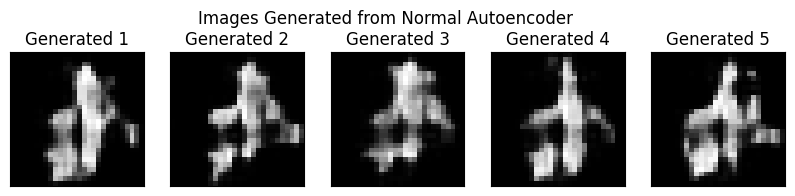

In [9]:
# Generate five noise vectors
num_images = 5
noise_vectors = np.random.normal(loc=5.0, scale=1.0, size=(num_images, latent_dim))

# Generate images from the noise vectors using the decoder
generated_images = decoder.predict(noise_vectors)

# Display the generated images
plt.figure(figsize=(10, 4))
for i in range(num_images):
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Generated {i+1}")
plt.suptitle("Images Generated from Normal Autoencoder")
plt.show()

# Q2: Generating Images from a Denoising Autoencoder

## Step 6: Create Noisy Data

In [10]:
# Add random noise to the images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

## Step 7: Build and Train the Denoising Autoencoder

In [11]:
# Define a new autoencoder for denoising
input_img_denoising = Input(shape=(28, 28, 1))

# Encoder (same architecture)
x_denoising = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img_denoising)
x_denoising = MaxPooling2D((2, 2), padding='same')(x_denoising)
x_denoising = Conv2D(16, (3, 3), activation='relu', padding='same')(x_denoising)
x_denoising = MaxPooling2D((2, 2), padding='same')(x_denoising)
x_denoising = Flatten()(x_denoising)
encoder_output_denoising = Dense(latent_dim, activation='relu')(x_denoising)

# Decoder (same architecture)
decoder_input_denoising = Input(shape=(latent_dim,))
x_denoising_dec = Dense(7 * 7 * 16, activation='relu')(decoder_input_denoising)
x_denoising_dec = Reshape((7, 7, 16))(x_denoising_dec)
x_denoising_dec = Conv2DTranspose(16, (3, 3), strides=2, activation='relu', padding='same')(x_denoising_dec)
x_denoising_dec = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x_denoising_dec)
decoder_output_denoising = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x_denoising_dec)


# Define models for denoising
encoder_denoising = Model(input_img_denoising, encoder_output_denoising, name="encoder_denoising")
decoder_denoising = Model(decoder_input_denoising, decoder_output_denoising, name="decoder_denoising")
denoising_autoencoder = Model(input_img_denoising, decoder_denoising(encoder_denoising(input_img_denoising)), name="denoising_autoencoder")

denoising_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the denoising autoencoder
denoising_autoencoder.fit(x_train_noisy, x_train,
                          epochs=20,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))

Epoch 1/20
469/469 [==============================] - 37s 76ms/step - loss: 0.3775 - val_loss: 0.3169
Epoch 2/20
469/469 [==============================] - 36s 76ms/step - loss: 0.3096 - val_loss: 0.3077
Epoch 3/20
469/469 [==============================] - 36s 76ms/step - loss: 0.3037 - val_loss: 0.3042
Epoch 4/20
469/469 [==============================] - 36s 76ms/step - loss: 0.3005 - val_loss: 0.3016
Epoch 5/20
469/469 [==============================] - 36s 76ms/step - loss: 0.2983 - val_loss: 0.2996
Epoch 6/20
469/469 [==============================] - 35s 75ms/step - loss: 0.2965 - val_loss: 0.2981
Epoch 7/20
469/469 [==============================] - 36s 76ms/step - loss: 0.2953 - val_loss: 0.2969
Epoch 8/20
469/469 [==============================] - 36s 76ms/step - loss: 0.2943 - val_loss: 0.2959
Epoch 9/20
469/469 [==============================] - 36s 76ms/step - loss: 0.2933 - val_loss: 0.2952
Epoch 10/20
469/469 [==============================] - 36s 76ms/step - loss: 0.292

## Step 8: Generate Images from the Denoising Autoencoder's Decoder

1/1 [==============================] - 0s 14ms/step


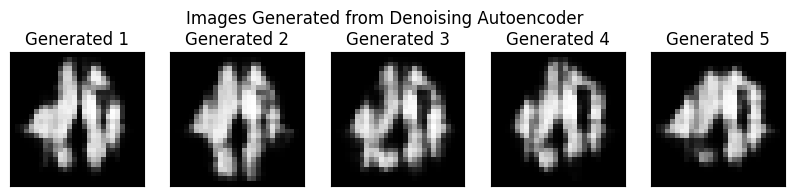

313/313 [==============================] - 2s 5ms/step


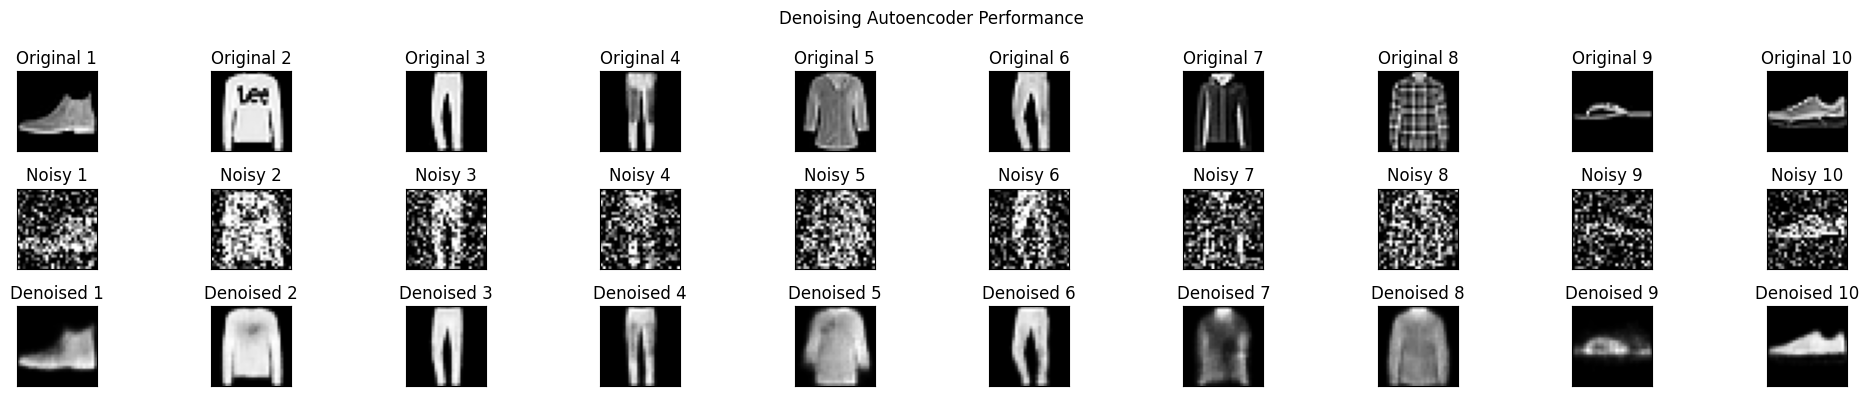

In [14]:
# Generate five new noise vectors
noise_vectors_denoising = np.random.normal(loc=5.0, scale=1.0, size=(num_images, latent_dim))

# Generate images from the noise vectors using the denoising decoder
generated_images_denoising = decoder_denoising.predict(noise_vectors_denoising)

# Display the generated images
plt.figure(figsize=(10, 4))
for i in range(num_images):
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(generated_images_denoising[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Generated {i+1}")
plt.suptitle("Images Generated from Denoising Autoencoder")
plt.show()

# You can also visualize the denoising effect on test images
denoised_images = denoising_autoencoder.predict(x_test_noisy)

plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Original {i+1}")
    if i == 0:
        ax.set_ylabel("Original", rotation=90, size='large')


    # display noisy
    ax = plt.subplot(3, 10, i + 1 + 10)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Noisy {i+1}")
    if i == 0:
        ax.set_ylabel("Noisy", rotation=90, size='large')

    # display reconstruction
    ax = plt.subplot(3, 10, i + 1 + 20)
    plt.imshow(denoised_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Denoised {i+1}")
    if i == 0:
        ax.set_ylabel("Denoised", rotation=90, size='large')
plt.suptitle("Denoising Autoencoder Performance")
plt.tight_layout()
plt.show()